In [637]:
#import modules
from keras.models import Sequential
from keras.layers import *
from keras.utils import load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os

In [632]:
image_height = 200
image_weight = 150
sequence = 3
sequence_length = 20

def arrange_data(df, map):
    image_data = []
    ids = df[df.columns[0]]
    map = f"{map}/raw_images/"
    
    df = df.drop(df.columns[0], axis=1)
    
    for i in ids:
        img = load_img(f"{map}{i}.jpg", target_size=(image_height, image_weight, sequence))
        img = img_to_array(img)
        image_data.append(img)
    
    X = np.array(image_data)
    Y = np.array(df)
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [633]:
# splitting data and scale
current_folder = os.path.abspath('')
map = f"{current_folder}/data/"

# reads first row as header
print("Processing train..")
train_df = pd.read_csv(f"{map}train.csv", delimiter=',', header=None)
X_train, Y_train = arrange_data(train_df, current_folder)

# reads first row double
print("Processing valid..")
val_df = pd.read_csv(f"{map}valid.csv", delimiter=',', header=0)
X_val, Y_val = arrange_data(val_df, current_folder)

# scale data 
X_train = X_train / 255
X_val = X_val / 255


Processing train..
Shape of images: (614, 200, 150, 3)
Shape of labels: (614, 26)
Processing valid..
Shape of images: (236, 200, 150, 3)
Shape of labels: (236, 26)


In [638]:
# sequential model

model=Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=512, kernel_size=(5, 5), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_weight, sequence)))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.1))



model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(26, activation='sigmoid'))

model.summary()

# multiple model generators

########################################################################################################################

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2, input_shape=(sequence, image_height, image_weight, sequence)))
    
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# model.add(TimeDistributed(Dropout(0.2)))

# model.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2))

# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
# #model.add(TimeDistributed(Dropout(0.2)))

# model.add(Flatten()) 

########################################################################################################################

# model.add(Conv2D(16, (3, 3), padding='same',activation = 'relu'), input_shape=(image_height, image_weight, sequence))
    
# model.add(MaxPooling2D((4, 4)))
# model.add(Dropout(0.25))

# model.add(Conv2D(32, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((4, 4)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), padding='same',activation = 'relu'))
# model.add(MaxPooling2D((2, 2)))
                                    
# model.add(Flatten())
# model.add(Dropout(0.25))
                                    
# model.add(LSTM(32))

########################################################################################################################



Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_556 (Conv2D)         (None, 196, 146, 16)      1216      
                                                                 
 max_pooling2d_549 (MaxPooli  (None, 98, 73, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_557 (Conv2D)         (None, 94, 69, 32)        12832     
                                                                 
 max_pooling2d_550 (MaxPooli  (None, 47, 35, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_558 (Conv2D)         (None, 43, 31, 64)        51264     
                                                                 
 max_pooling2d_551 (MaxPooli  (None, 22, 16, 64)    

In [635]:
version = 'v11'

opt = optimizers.SGD(
    learning_rate=0.01, 
    decay=1e-3, 
    momentum=0.95, 
    nesterov=True
    )

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    mode='min',
    restore_best_weights=True
    )

model.compile(
    loss='binary_crossentropy', 
    metrics=[metrics.Precision()], 
    optimizer=opt
    # optimizer='Adam'
    # optimizer=optimizers.RMSprop(lr=1e-4)
    )

history = model.fit(X_train, Y_train, 
                    epochs=21, 
                    batch_size=64,
                    shuffle = True, 
                    # validation_split = 0.2,
                    validation_data=(X_val, Y_val), 
                    callbacks=[early_stopping_callback]
                    )

model.save(f'{current_folder}/model/generated/{version}/Model_6c_{version}.h5')

Epoch 1/21
10/10 [==============================] - 10s 920ms/step - loss: 0.5562 - precision_46: 0.1090 - val_loss: 0.3190 - val_precision_46: 0.2575
Epoch 2/21
10/10 [==============================] - 9s 896ms/step - loss: 0.2931 - precision_46: 0.3671 - val_loss: 0.2561 - val_precision_46: 0.4714
Epoch 3/21
10/10 [==============================] - 9s 920ms/step - loss: 0.2567 - precision_46: 0.4943 - val_loss: 0.2370 - val_precision_46: 0.6500
Epoch 4/21
10/10 [==============================] - 9s 891ms/step - loss: 0.2479 - precision_46: 0.5051 - val_loss: 0.2323 - val_precision_46: 0.4583
Epoch 5/21
10/10 [==============================] - 9s 903ms/step - loss: 0.2443 - precision_46: 0.4608 - val_loss: 0.2304 - val_precision_46: 0.7273
Epoch 6/21
10/10 [==============================] - 9s 875ms/step - loss: 0.2409 - precision_46: 0.5833 - val_loss: 0.2276 - val_precision_46: 0.8462
Epoch 7/21
10/10 [==============================] - 9s 895ms/step - loss: 0.2396 - precision_46: 0.

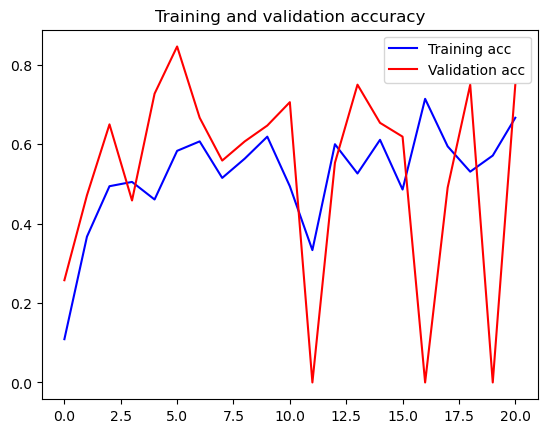

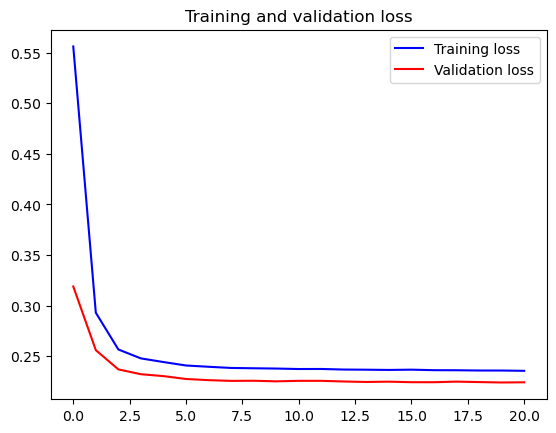

In [636]:
v = '46'
acc = history.history[f'precision_{v}']
val_acc = history.history[f'val_precision_{v}']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()